In [1]:
from sqlalchemy import create_engine
from operator import itemgetter
import json
import math

import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
engine = create_engine('sqlite:///tab.db')
conn = engine.connect()

dfo = pd.read_sql_table('race', conn)
print('{} races loaded!'.format(len(dfo)))

9299 races loaded!


In [3]:
category = 'G'
dfo = dfo.loc[dfo['race_type'].isin([category])]
print('{} {} races!'.format(len(dfo), category))

3796 G races!


In [4]:
dfo['results'] = dfo['results_data'].map(json.loads)
dfo['runners'] = dfo['runners_data'].map(json.loads)
dfo.describe()

,id,race_number,race_distance,num_runners
count,3796.000000,3796.000000,3796.000000,3796.000000
mean,5195.928082,6.391992,435.177028,7.641201
std,2899.775745,3.288368,82.814514,0.777367
min,1.000000,1.000000,0.000000,4.000000
25%,3011.750000,4.000000,390.000000,8.000000
50%,5290.500000,6.000000,431.000000,8.000000
75%,7714.250000,9.000000,515.000000,8.000000
max,9971.000000,12.000000,732.000000,10.000000


In [5]:
# bet size
balance = 1000
bet_chunk = balance * 0.01

In [6]:
def bettable(r):
    return r['probability'] > r['odds_scale'] and r['odds_win'] > 0

In [7]:
def process_strategy(df, strategy):
    """run strategy, must pass runners returned back into results (it might be modified)"""
    book = []
    for _, race in df.iterrows():
#         print(race['num_runners'])
        runners = race['runners']
        
        # drop scratched
        runners = [r for r in runners if r['odds_win']]
        if not runners:
            continue
    
        # default 0 bets
        for runner in runners:
            runner['bet'] = 0
        
        runners, num_bets = strategy(runners, bet_chunk)
        if num_bets:
            bet_results(book, runners, race['num_runners'], bet_chunk, num_bets, race['race_type'])
    return book

In [8]:
def bet_results(book, runners, num_runners, bet_chunk, num_bets, race_type):
    """get results from bets"""
    win_diff = 0
    max_diff = 0
    outcome = {
        'success': 0,
        'profit': -bet_chunk,
        'num_bets': num_bets,
        'num_runners': num_runners,
    }
    for i, runner in enumerate(runners):
        diff = abs(runner['odds_scale'] - runner['probability'])
        max_diff = max(max_diff, diff)
        if int(runner['finishingPosition']) == 1:
            win_diff = diff
            if runner['bet'] > 0:
                # odds = runner['parimutuel']['returnWin'] if runner['parimutuel']['returnWin'] else runner['odds_win']
                odds = runner['odds_win']
                profit = runner['bet'] * odds - bet_chunk
                outcome = {
                    'success': 1,
                    'profit': profit,
                    'num_bets': num_bets,
                    'num_runners': num_runners,
                }
            break

    outcome['max_diff'] = max_diff
    outcome['win_diff'] = win_diff
    outcome['bet_chunk'] = bet_chunk
    outcome['race_type'] = race_type
    outcome['runners'] = runners
    book.append(outcome)

In [30]:
def bet_positive_max(runners, bet_chunk):
    """bet max given prob>scale"""

    diffs = [(r['probability'] - r['odds_scale'], r) for r in runners]
    diffs.sort(key=itemgetter(0), reverse=True)

    ##############################################################################################
    # -1% roi 42% wr 100% races
    ##############################################################################################
#     num_bets = math.ceil(len(runners) * 0.125)


    ##############################################################################################
    # -2% roi 29% wr 100% races
    ##############################################################################################
    num_bets = 1


    ##############################################################################################
    # 10% roi 35% wr 33% races
    ##############################################################################################
#     num_bets = 1
#     if len(runners) > 8:
#         return [], 0

    
    ##############################################################################################
    # -3% roi 31% wr 77% races
    ##############################################################################################
#     num_bets = 1
#     if len(runners) > 12:
#         return [], 0

    
    ##############################################################################################
    # 0% roi 53% wr 33% races
    ##############################################################################################
#     num_bets = 2
#     if len(runners) > 8:
#         return [], 0

    total_probs = sum(d[1]['probability'] for d in diffs[:num_bets])
    for d, r in diffs[:num_bets]:
        r['bet'] = bet_chunk * r['probability'] / total_probs

    runners = [d[1] for d in diffs]
    return runners, num_bets


dfo = dfo.sample(frac=1).reset_index(drop=True)
print('Dataframe shuffled!')

book = process_strategy(dfo, bet_positive_max)

Dataframe shuffled!


In [39]:
def bet_positive_dutch(runners, bet_chunk):
    """dutch betting on probability"""

    # sort runners from favourite to underdog
    ###############################################################################################
    # -10% roi 69% wr 100% races
    # runners.sort(key=itemgetter('probability'), reverse=True)
    ###############################################################################################
    # -7% roi 68% wr 100% races
    runners.sort(key=lambda r: r['probability'] - r['odds_scale'], reverse=True)
    ###############################################################################################
    
    # start betting on all and cut off worse runner till positive outcome
    for num_bets in range(len(runners), 0, -1):

        # reset bets for every iteration
        for runner in runners:
            runner['bet'] = 0

        # recreate smaller pool
        pool = runners[:num_bets]
        # print('pool is {} from {} bets'.format(len(pool), num_bets))

        # all odds
        total_probs = sum([r['probability'] for r in pool])
#         total_scale = sum([r['odds_scale'] for r in pool])
        # print('total probability = {}'.format(total))

        # dutch for all in pool
        profits = []
        for runner in pool:

            # scale bet according to odds or prediction?
            ###################################################################################
            # -7% roi 68% wr
            runner['bet'] = bet_chunk * runner['probability'] / total_probs
            ###################################################################################
            # -13% roi 79% wr 100% races
            # runner['bet'] = bet_chunk * runner['odds_scale'] / total_scale
            ###################################################################################
            
            # need to check all as we scale to probs and not odds
            profits.append(runner['bet'] * runner['odds_win'] - bet_chunk)

        # exit with average profit
        avg_profit = sum(profits) / len(profits)
        ###################################################################################
        # -9% roi 76% wr 30/30
        #if avg_profit > 0:
        ###################################################################################
        # -1% roi 38% wr 26/30
        #if avg_profit > bet_chunk * 1:
        ###################################################################################
        # 1% roi 25% wr 19/30
        #if avg_profit > bet_chunk * 2:
        ###################################################################################
        # -4% roi 18% wr 13/30
        #if avg_profit > bet_chunk * 3:
        ###################################################################################

        # exit with minimum profit
        ###################################################################################
        # -7% roi 68% wr
        #if all(p > 0 for p in profits):
        ###################################################################################
        # 0% roi 35% wr 26/31
        # if min(profits) > bet_chunk * 1:
        ###################################################################################
        # 2% roi 28% wr 22/31
        #if min(profits) > bet_chunk * 1.5:
        ###################################################################################
        # 4% roi 24% wr 19/31
        #if min(profits) > bet_chunk * 2:
        ###################################################################################
        # 3% roi 21% wr 17/31
        #if min(profits) > bet_chunk * 2.5:
        ###################################################################################
        # -1% roi 18% wr 13/31
        #if min(profits) > bet_chunk * 3:
        ###################################################################################
        
        #4%  2 - 2
        #3%  1.745 - 1.75
        #2%  2.25 - 1.75
        #2%  2 - 2.25
        #3.7% 1.7 - 2
        #3.7% 1.8 - 2
        #3.7% 1.9 - 2 (1.9 5.1% - 1.8 5.3% - 1.7 4.9%)
        #3.4% 2.1 - 2
        # 5.0 (1.8,1.8)
        # 4.0 (2, 1.8)
#         if avg_profit > bet_chunk * 1.9 and min(profits) > bet_chunk * 1.8:
        if min(profits) > 0:
            break
    else:
        #print('no profit determined')
        return [], 0
    
    return pool, num_bets


dfo = dfo.sample(frac=1).reset_index(drop=True)
print('Dataframe shuffled!')

book = process_strategy(dfo, bet_positive_dutch)

Dataframe shuffled!


In [40]:
df = pd.DataFrame(book)
df.tail(10)

,bet_chunk,max_diff,num_bets,num_runners,profit,race_type,runners,success,win_diff
3786,10.0,0.036341,3,8.0,-10.000000,G,"[{'runnerName': 'FAMES THE AIM', 'runnerNumber...",0,0.000000
3787,10.0,0.039350,3,8.0,1.057165,G,"[{'runnerName': 'FERNANDO EXPRESS', 'runnerNum...",1,0.039350
3788,10.0,0.014428,5,8.0,0.312075,G,"[{'runnerName': 'ELITE MARJ', 'runnerNumber': ...",1,0.014428
3789,10.0,0.032058,3,8.0,0.644973,G,"[{'runnerName': 'RED ONES', 'runnerNumber': 8,...",1,0.032058
3790,10.0,0.177419,3,9.0,2.409253,G,"[{'runnerName': 'NOT AVAILABLE', 'runnerNumber...",1,0.177419
3791,10.0,0.010189,2,6.0,-10.000000,G,"[{'runnerName': 'CRONIN', 'runnerNumber': 1, '...",0,0.000000
3792,10.0,0.023906,3,8.0,-10.000000,G,"[{'runnerName': 'MIJA SYDNEY', 'runnerNumber':...",0,0.000000
3793,10.0,0.093730,2,8.0,2.591040,G,"[{'runnerName': 'ROSA TEE', 'runnerNumber': 7,...",1,0.093730
3794,10.0,0.011809,4,8.0,1.540445,G,"[{'runnerName': 'MAURICE MINOR', 'runnerNumber...",1,0.011809
3795,10.0,0.078829,2,8.0,2.453262,G,"[{'runnerName': 'TRULY DOMINANT', 'runnerNumbe...",1,0.078829


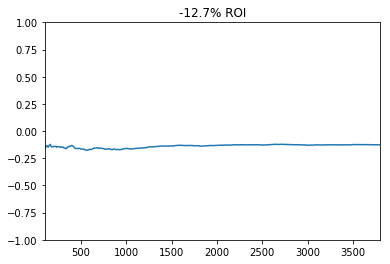

In [41]:
# ROI
roi = df.profit.cumsum() / df.bet_chunk.cumsum()
roi_title = '{:.1f}% ROI'.format(roi.iloc[-1] * 100)
roi.rolling(10).mean().plot(title=roi_title, xlim=(100), ylim=(-1, 1))

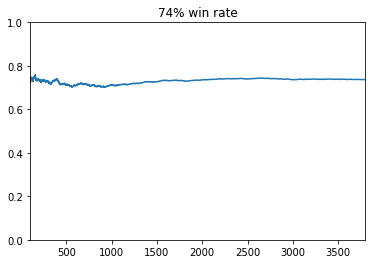

In [42]:
df['ones'] = np.ones(len(df))
df['win_rate'] = df.success.cumsum() / df.ones.cumsum()
win_title = '{:.0f}% win rate'.format(df.win_rate.iloc[-1] * 100)
df.win_rate.plot(title=win_title, xlim=(100), ylim=(0, 1))

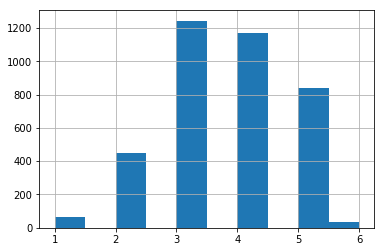

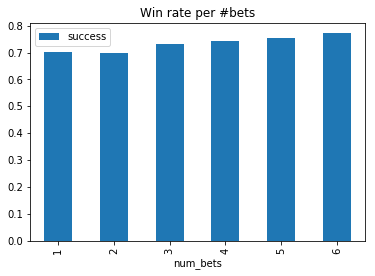

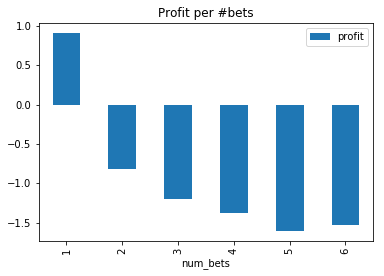

In [43]:
# profit per num bets 
df.num_bets.hist()
groups = df.groupby('num_bets').mean()
groups.plot(kind='bar', y='success', title='Win rate per #bets')
groups.plot(kind='bar', y='profit', title='Profit per #bets')

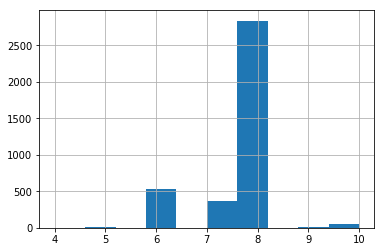

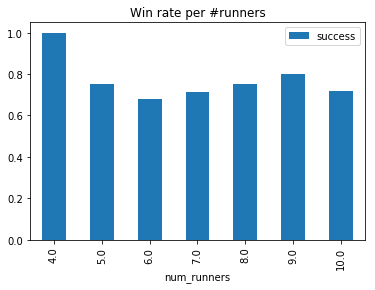

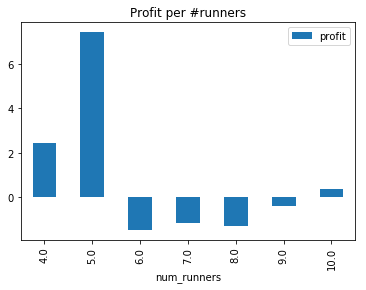

In [44]:
# profit per num runners
df.num_runners.hist()
groups = df.groupby('num_runners').mean()
groups.plot(kind='bar', y='success', title='Win rate per #runners')
groups.plot(kind='bar', y='profit', title='Profit per #runners')

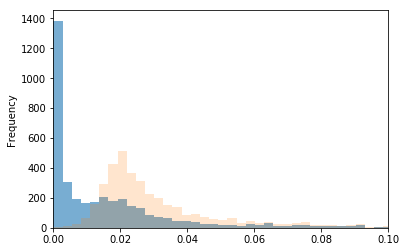

In [45]:
# max diff
df.win_diff.plot(kind='hist', xlim=(0, 0.1), bins=200, alpha=0.6)
df.max_diff.plot(kind='hist', xlim=(0, 0.1), bins=200, alpha=0.2)

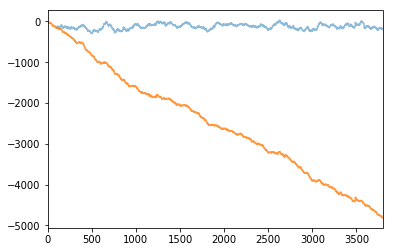

In [46]:
df.profit.rolling(100).sum().plot(alpha=0.5)
df.profit.cumsum().plot(alpha=0.8)

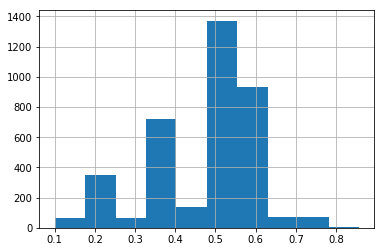

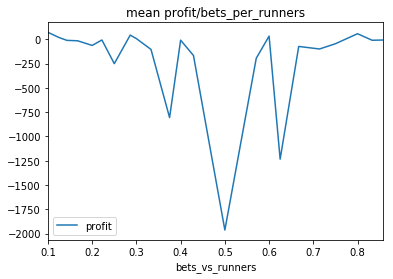

In [47]:
# bets/runners
df['bets_vs_runners'] = df.num_bets / df.num_runners
df['bets_vs_runners'].hist(bins=10)
groups = df.groupby(df['bets_vs_runners'].apply(lambda x: round(x, 3))).sum()
groups.plot(kind='line', y='profit', title='mean profit/bets_per_runners')